In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [20]:
test = pd.read_csv("C:/박규영/dna 동아리/전력예측/전처리test.csv", encoding='euc-kr')
train = pd.read_csv("C:/박규영/dna 동아리/전력예측/train_cluster.csv",encoding='euc-kr')

#### 연속형변수 분포도 시각화

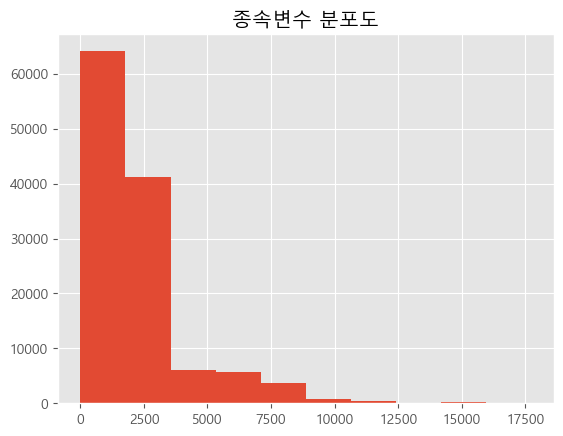

In [32]:
plt.hist(train['target'],bins=10)
plt.title('종속변수 분포도')
plt.show();

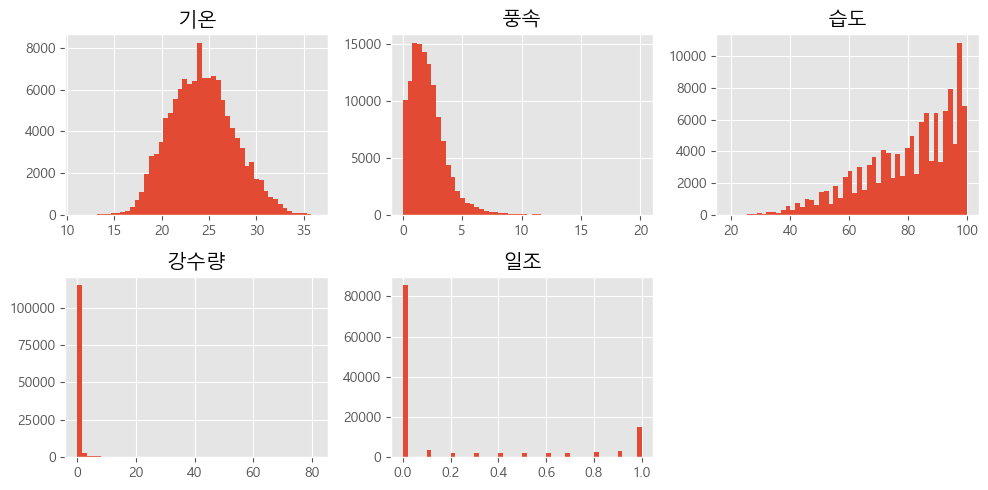

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes.flatten()):
    if i < 5:  # only plot the first 5 subplots
        ax.hist(train.iloc[:,i+5],bins=50)
        ax.set_title(f"{train.columns[i+5]}")
    else:
        # Hide the extra subplot(s)
        ax.axis('off')

plt.tight_layout()
plt.show();

- 종속변수: 로그변환 후, 표준화 필요
- 독립변수 중 풍속, 습도, 강수량, 일조 역시 로그변환 후, 표준화. 기온은 표준화만 진행
- 표준화를 진행하는 이유: 모든 변수들의 최소 최댓값 스케일을 동일하게 해줘야 회귀계수가 명확하게 표현됨

In [99]:
cl = train[train['클러스터4']==1]
cl['건물번호'].unique()

array([ 2,  6,  7,  8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 33,
       35, 36, 37, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57],
      dtype=int64)

In [21]:
def cluster1(df):
    
    df = df[df['클러스터4']==1]
    df['주간그룹'] = None
    df['야간그룹'] = None

    df['주간그룹'] = (df['시간'] >= 7) & (df['시간'] <= 18)
    df['주간그룹'] = df['주간그룹'].astype(int)

    df['야간그룹'] = (df['시간'] < 7) | (df['시간'] > 18)
    df['야간그룹'] = df['야간그룹'].astype(int)
    
    df.drop(columns=['전력사용량','클러스터','클러스터4','date_time','요일','시간','연도','월','일'],inplace=True)
    
    df = pd.get_dummies(df, columns=['비전기냉방설비운영', '태양광보유','주말'])
    
    return df 

train = cluster1(train)

In [22]:
from sklearn.preprocessing import StandardScaler

train['target'] = np.log1p(train['target']) # 로그변환

scaler = StandardScaler() # StandardScaler 객체 생성
data_to_scale = train[['기온','풍속','습도','강수량','일조','체감온도','불쾌지수']]
scaled_data = scaler.fit_transform(data_to_scale) # 데이터 표준화
train[['기온','풍속','습도','강수량','일조','체감온도','불쾌지수']] = scaled_data 
# 표준화된 데이터를 train 데이터에 다시 적용

In [173]:
for i in range(1, 61):
    mean_ = train.loc[train.건물번호 == i].target.mean()
    std_ = train.loc[train.건물번호 == i].target.std()
    train.loc[train.건물번호 == i, 'target'] = ((train.loc[train.건물번호 == i, 'target']) - mean_) / std_

In [23]:
train.drop(columns=['건물번호'],inplace=True)

In [24]:
# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))

In [25]:
# 트레인 테스트 세트 분리
X_features = train.drop(columns=['target'],axis=1)
y_target = train['target']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# X_train에 상수항 추가
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# 회귀 모델 적합
full_model = sm.OLS(y_train, X_train)
fitted_full_model = full_model.fit()

# 회귀분석 결과 출력
fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     411.6
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        08:55:06   Log-Likelihood:            -1.0551e+05
No. Observations:               45696   AIC:                         2.111e+05
Df Residuals:                   45684   BIC:                         2.112e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
기온                0.8790      0.114      7.735      0.000       0.656       1.102
풍속               -0.1522      0.014    -10.834      0.000      -0.180      -0.125
습도                0.1859      0.040      4.655      0.000       0.108       0.264
강수량               0.0098      0.012      0.834      0.404      -0.013       0.033
일조                0.0003      0.017      0.020      0.984      -0.033       0.034
체감온도             -0.4966      0.086     -5.795      0.000      -0.665      -0.329
불쾌지수             -0.1926      0.053     -3.643      0.000      -0.296      -0.089
주간그룹              0.7394      0.014     52.741      0.000       0.712       0.767
야간그룹             -0.0979      0.014     -7.015      0.000      -0.125      -0.071
비전기냉방설비운영_0.0    -0.2559      0.016    -16.482      0.000      -0.286      -0.225
비전기냉방설비운영_1.0     0.8974      0.012     73.322      0.000       0.873       0.921
태양광보유_0.0         0.1330      0.012     10.719      0.000       0.109       0.157
태양광보유_1.0         0.5086      0.012     42.534      0.000       0.485       0.532
주말_0              0.6666      0.012     56.554      0.000       0.643       0.690
주말_1             -0.0250      0.014     -1.732      0.083      -0.053       0.003
==============================================================================
Omnibus:                    43817.846   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2095368.483
Skew:                           4.722   Prob(JB):                         0.00
Kurtosis:                      34.801   Cond. No.                     1.20e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

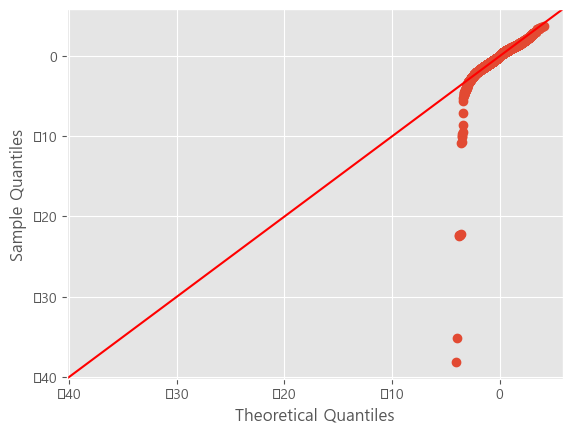

In [176]:
# 학습데이터의 잔차 확인

res = fitted_full_model.resid
fig =sm.qqplot(res,fit = True,line = '45') # q-q plot을 통한 잔차의 정규분포 확인
plt.show();

In [15]:
pred_y = fitted_full_model.predict(X_train) # train_x 데이터를 이용해 모델의 예측값을 계산
residuals = y_train - pred_y # 잔차(residual)를 계산
pred_y2 = fitted_full_model.predict(X_test)

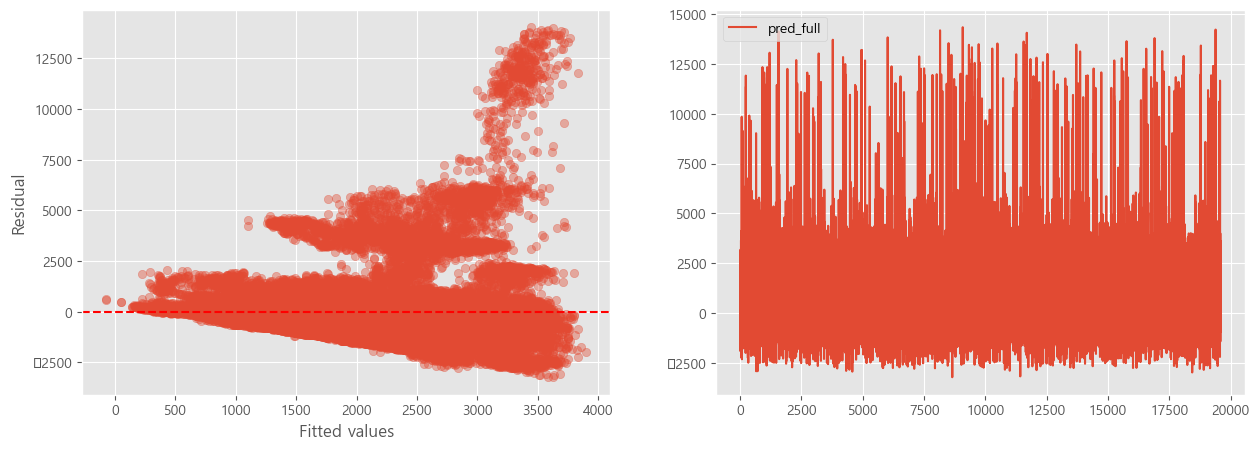

In [16]:
plt.figure(figsize=(15,5))

# 잔차패턴 확인

plt.subplot(1,2,1)
plt.scatter(pred_y, residuals, alpha=0.4)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')

# 예측데이터 잔차

plt.subplot(1,2,2)
plt.plot(np.array(y_test - pred_y2), label = "pred_full")
plt.legend()

plt.show()

In [179]:
pred_y = fitted_full_model.predict(X_train) # train_x 데이터를 이용해 모델의 예측값을 계산
residuals = y_train - pred_y # 잔차(residual)를 계산
pred_y2 = fitted_full_model.predict(X_test)
residuals2 = y_test - pred_y2

outliers = pd.DataFrame({'pred_y': pred_y, 'residuals': residuals})
outliers2 = pd.DataFrame({'pred_y': pred_y2, 'residuals': residuals2})

print('테스트셋에서의 이상치 인덱스', outliers2[np.abs(outliers2['residuals']) > 3].index)
print('트레인셋에서의 이상치 인덱스', outliers[np.abs(outliers['residuals']) > 3].index)

테스트셋에서의 이상치 인덱스 Int64Index([115547, 46943, 46941, 46939, 46935, 111803, 46934, 104298, 115378,
            46940],
           dtype='int64')
트레인셋에서의 이상치 인덱스 Int64Index([ 46937,  46942,  49955,  46936,  49954,  65537,  54685,  90577,
             27014,  55018,  55044,  73135,  46954,  46938,  54686, 115379,
             54688,  54684,  54687,  46953,  61457],
           dtype='int64')


In [180]:
train = train.drop(outliers2[np.abs(outliers2['residuals']) > 3].index)
train = train.drop(outliers[np.abs(outliers['residuals']) > 3].index)

### 이상치 제거 후 회귀분석 결과

In [181]:
# 트레인 테스트 세트 분리
X_features = train.drop(columns=['target'],axis=1)
y_target = train['target']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# X_train에 상수항 추가
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# 회귀 모델 적합
full_model = sm.OLS(y_train, X_train)
fitted_full_model = full_model.fit()

# 회귀분석 결과 출력
fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7374.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:03:29   Log-Likelihood:                -40572.
No. Observations:               45674   AIC:                         8.117e+04
Df Residuals:                   45662   BIC:                         8.127e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
기온                0.3858      0.028     13.936      0.000       0.332       0.440
풍속                0.0140      0.003      4.078      0.000       0.007       0.021
습도                0.0289      0.010      2.996      0.003       0.010       0.048
강수량               0.0005      0.003      0.174      0.862      -0.005       0.006
일조                0.0001      0.004      0.030      0.976      -0.008       0.008
체감온도             -0.1501      0.021     -7.139      0.000      -0.191      -0.109
불쾌지수              0.0477      0.013      3.744      0.000       0.023       0.073
주간그룹              0.4810      0.003    142.007      0.000       0.474       0.488
야간그룹             -0.5764      0.003   -171.030      0.000      -0.583      -0.570
비전기냉방설비운영_0.0    -0.0398      0.004    -10.635      0.000      -0.047      -0.032
비전기냉방설비운영_1.0    -0.0556      0.003    -18.806      0.000      -0.061      -0.050
태양광보유_0.0        -0.0485      0.003    -16.186      0.000      -0.054      -0.043
태양광보유_1.0        -0.0470      0.003    -16.248      0.000      -0.053      -0.041
주말_0              0.4080      0.003    143.343      0.000       0.402       0.414
주말_1             -0.5035      0.003   -144.391      0.000      -0.510      -0.497
==============================================================================
Omnibus:                      493.904   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.861
Skew:                          -0.257   Prob(JB):                    1.93e-111
Kurtosis:                       3.066   Cond. No.                     1.70e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.31e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

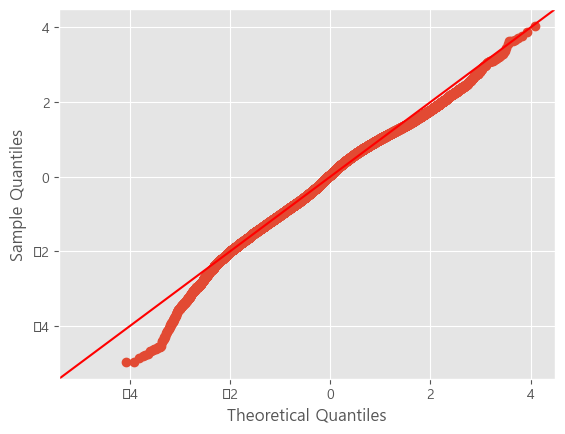

In [182]:
# 학습데이터의 잔차 확인

res = fitted_full_model.resid
fig =sm.qqplot(res,fit = True,line = '45') # q-q plot을 통한 잔차의 정규분포 확인
plt.show();

In [183]:
pred_y = fitted_full_model.predict(X_train) # train_x 데이터를 이용해 모델의 예측값을 계산
residuals = y_train - pred_y # 잔차(residual)를 계산
pred_y2 = fitted_full_model.predict(X_test)

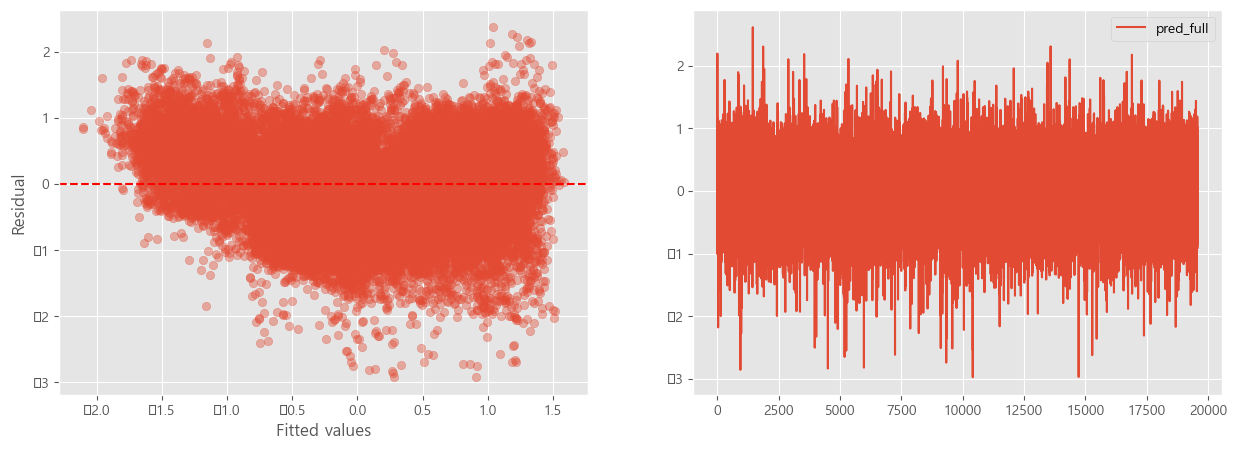

In [184]:
plt.figure(figsize=(15,5))

# 잔차패턴 확인

plt.subplot(1,2,1)
plt.scatter(pred_y, residuals, alpha=0.4)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')

# 예측데이터 잔차

plt.subplot(1,2,2)
plt.plot(np.array(y_test - pred_y2), label = "pred_full")
plt.legend()

plt.show()

- 결정계수가 상승하였으며
- qqplot과 잔차패턴에서 역시 이상치가 잘 제거된 것을 확인

### VIF 확인 및 변수선택 

In [185]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif["features"] = train.columns

vif.sort_values(by='VIF Factor',ascending=False)

,VIF Factor,features
8,inf,주간그룹
9,inf,야간그룹
10,inf,비전기냉방설비운영_0.0
11,inf,비전기냉방설비운영_1.0
12,inf,태양광보유_0.0
13,inf,태양광보유_1.0
14,inf,주말_0
15,inf,주말_1
0,101.033093,기온
5,57.694075,체감온도


In [186]:
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [187]:
print(feature_engineering_XbyVIF(train,10))
print(feature_engineering_XbyVIF(train,8))
print(feature_engineering_XbyVIF(train,7))

['강수량' '풍속' '일조' 'target' '습도' '불쾌지수' '체감온도' '기온' '주간그룹' '야간그룹']
['강수량' '풍속' '일조' 'target' '습도' '불쾌지수' '체감온도' '기온']
['강수량' '풍속' '일조' 'target' '습도' '불쾌지수' '체감온도']


In [189]:
# 트레인 테스트 세트 분리
X_features = train[['풍속', '습도', '기온','주간그룹','야간그룹','주말_0']]
y_target = train['target']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# X_train에 상수항 추가
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# 회귀 모델 적합
full_model = sm.OLS(y_train, X_train)
fitted_full_model = full_model.fit()

# 회귀분석 결과 출력
fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                 1.618e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:04:58   Log-Likelihood:                -40612.
No. Observations:               45674   AIC:                         8.124e+04
Df Residuals:                   45668   BIC:                         8.129e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
풍속             0.0273      0.003      9.459      0.000       0.022       0.033
습도             0.0638      0.003     19.470      0.000       0.057       0.070
기온             0.2886      0.003     86.173      0.000       0.282       0.295
주간그룹          -0.1213      0.006    -19.970      0.000      -0.133      -0.109
야간그룹          -1.1790      0.006   -197.319      0.000      -1.191      -1.167
주말_0           0.9110      0.006    148.793      0.000       0.899       0.923
==============================================================================
Omnibus:                      483.580   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.872
Skew:                          -0.254   Prob(JB):                    4.69e-109
Kurtosis:                       3.065   Cond. No.                         4.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- skew, kurtosis: 회귀모델의 왜도와 첨도
- durbin-watson: 회귀모델 잔차의 독립성 

In [190]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSE: 0.592, MAE: 0.486


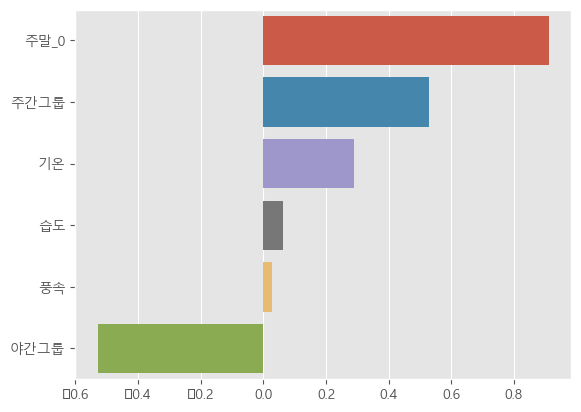

In [191]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

In [198]:
building_numbers = [2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 33, 35, 36, 37, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]
test = test.loc[test['건물번호'].isin(building_numbers)]

In [199]:
test

,건물번호,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수
168,2,2020-08-25 00:00:00,26.7,0.9,87.0,0.0,0.0,1.0,0.0,2020,8,25,0,화,0,28.943696,1123.498
169,2,2020-08-25 01:00:00,26.7,0.9,87.0,0.0,0.0,1.0,0.0,2020,8,25,1,화,0,28.943696,1123.498
170,2,2020-08-25 02:00:00,26.7,0.9,87.0,0.0,0.0,1.0,0.0,2020,8,25,2,화,0,28.943696,1123.498
171,2,2020-08-25 03:00:00,26.2,0.9,87.0,0.0,0.0,1.0,0.0,2020,8,25,3,화,0,28.438010,1080.028
172,2,2020-08-25 04:00:00,26.2,0.9,87.0,0.0,0.0,1.0,0.0,2020,8,25,4,화,0,28.438010,1080.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9571,57,2020-08-31 19:00:00,25.7,0.2,99.0,10.0,0.0,1.0,0.0,2020,8,31,19,월,0,28.180480,1170.274
9572,57,2020-08-31 20:00:00,25.7,0.2,99.0,10.0,0.0,1.0,0.0,2020,8,31,20,월,0,28.180480,1170.274
9573,57,2020-08-31 21:00:00,26.2,0.8,99.0,10.0,0.0,1.0,0.0,2020,8,31,21,월,0,28.456031,1219.684
9574,57,2020-08-31 22:00:00,26.2,0.8,99.0,10.0,0.0,1.0,0.0,2020,8,31,22,월,0,28.456031,1219.684


In [200]:
test['주간그룹'] = None
test['야간그룹'] = None

test['주간그룹'] = (test['시간'] >= 7) & (test['시간'] <= 18)
test['주간그룹'] = test['주간그룹'].astype(int)

test['야간그룹'] = (test['시간'] < 7) | (test['시간'] > 18)
test['야간그룹'] = test['야간그룹'].astype(int)
    
test.drop(columns=['date_time','요일','시간','연도','월','일'],inplace=True)
    
test = pd.get_dummies(test, columns=['비전기냉방설비운영', '태양광보유','주말'])

In [201]:
scaler = StandardScaler() # StandardScaler 객체 생성
data_to_scale = test[['기온','풍속','습도','강수량','일조','체감온도','불쾌지수']]
scaled_data = scaler.fit_transform(data_to_scale) # 데이터 표준화
test[['기온','풍속','습도','강수량','일조','체감온도','불쾌지수']] = scaled_data 

In [204]:
X_test = test[['풍속', '습도', '기온','주간그룹','야간그룹','주말_0']]
y_pred = fitted_full_model.predict(X_test)
test['예측값'] = y_pred
test['예측값']

168    -0.407071
169    -0.407071
170    -0.407071
171    -0.466827
172    -0.466827
          ...   
9571   -0.474676
9572   -0.474676
9573   -0.405253
9574   -0.405253
9575   -0.405253
Name: 예측값, Length: 5376, dtype: float64